<a href="https://colab.research.google.com/github/hywkim-private/ALIGNet/blob/main/ALIGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install imgaug

In [ ]:
pip install wget

In [ ]:
import torch 
import torchvision
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2, wget
from zipfile import ZipFile
import h5py 
from imgaug import augmenters as iaa
from pathlib import Path
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import random_split
from torchsummary import summary

In [ ]:
#define hyper parameters 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 300
BATCH_SIZE = 5

TARGET_PROPORTION = 0.5
TARGET_PROPORTION_VAL = 0.5
TARGET_PROPORTION_TEST = 0.5
VAL_SIZE = 20
N_CLASS = 10
TEST_SIZE = 10
IMAGE_SIZE =128

#parameters for mask operation
MASK_SIZE = 60
MASK_STRIDE = 20

#parameters for the warp-field/grid
GRID_SIZE = 8


FILE_PATH = '../data/h5files'

In [ ]:
image_url = 'https://drive.google.com/uc?export=download&id=1Vv-Jz1VpI48MOVgK3Hq6ZYrs2NDP-FQ2'
filename = wget.download(image_url)
zf = ZipFile(filename, 'r')
zf.extractall('../data')
zf.close()

In [ ]:
#DATA LOADING ROUTINES

#This class must be fine-tuned after completing the model, so as to be able to read from any h5 input formats
class Load_HDF5(Dataset):
  # if get_all == True, file_path must specifiy a directory, if not, it should specify a file
  # the class will crash if this requirement is not met
  def __init__(self, file_path, get_all = False, transform = None):
    self.path = file_path
    self.transform = transform
    #if filename is None, perform a recursive search over the file directory and retrieve all .h5 files
    p = Path(file_path)
    if get_all == True:
      files = sorted(p.glob('*.h5'))
      data_list = []
      for file in files:
        data_list.append(self.get_file(str(file)))
      self.data = data_list
    else:
      self.data = self.get_file(str(file))

  #given a filepath, return the image object
  def get_file(self, path):
    with h5py.File(path, 'r') as file:
      data = file['dep']
      data = data.get('view1')[:]
      return data
    
  def __getitem__(self, index):
    if len(self.data) <= index:
      print("__getitem__ERROR: index out of range")
      return 
    else:
      x = self.data[index]
      x = x.astype('float32')
      if self.transform:
        x = self.transform(x)
      return x

  def __len__(self):
    return len(self.data)

#A dataset to perform the operation of expanding the size of the dataset
class Expand(Dataset):
  def __init__(self, tar_img, expand_size=None):
    self.tar_img = tar_img
    self.expand_size = expand_size
    tar_list = []
    while len(tar_img)*len(tar_list) + len(tar_img) < expand_size:
      tar_list.append(tar_img)
    #handle for the remaining number of img to fullfill the expand_size
    if not len(tar_img)*len(tar_list) == expand_size:
      tail_length = expand_size - len(tar_img) * len(tar_list) - 1
      tar_img, dump = random_split(tar_img, [tail_length, len(tar_img)-tail_length])
      tar_list.append(tar_img)
    self.tar_list = torch.utils.data.ConcatDataset(tar_list)
  def __getitem__(self, index):
    x = self.tar_list[index]
    return x
  def __len__(self):
    return len(self.tar_list)

#given source and target img dataset, return a dict of augmented datasets
#if val_set is set to True, the loader returns one element, not two
class Augment(Dataset):
  def __init__(self, tar_img, batch_size, im_size, val_set=False, augment_times=0, transform=False, random_mask=False, elastic=False, grid_distort=False, rotate=False, scale=False, translate=False, shear=False):
    self.val_set = val_set
    self.transform = transform
    self.random_mask = random_mask
    self.batch_size = batch_size
    self.aug = random_augmentation(elastic, grid_distort, rotate, scale, translate, shear)
    self.augment_times = augment_times
    #first augment the original tar_list to match the returning batch size, then perform augmentation
    tar_list = []
    for i in range(self.augment_times):
      tar_list.append(tar_img)
    self.tar_list = torch.utils.data.ConcatDataset(tar_list)
    self.aug_list = torch.utils.data.ConcatDataset(tar_list)
    self.im_size = im_size

  def __getitem__(self, index):
    #return augmented list when val_set is set to true
    if self.val_set:
      y = self.aug_list(index)
      return y
    #if not, return both tar_list and aug_list
    x = self.tar_list[index]
    y = self.aug_list[index]
    return x,y

  def __len__(self):
    return len(self.tar_list)

  #perform the deformation operation on batch of images
  #input shape: batchx NxWxH
  def deform(self, aug_batch):
    if not (self.augment_times == None):
      aug_im = self.aug.augment_images(images=aug_batch)
    return aug_im

  #perform the mask operation on a batch 
  #return both the augmented image and the original image 
  #input shape: batchx NxWxH
  def mask(self, aug_batch):
    tar_batch = aug_batch
    if not (self.random_mask == None):
      aug_im = random_mask_2d(aug_batch, self.im_size, (20, 60), square=True)
    return aug_im, tar_batch

  def collate_fn(self, batch):
    aug_batch, tar_batch = zip(*batch)
    aug_batch = np.concatenate(list(aug_batch))
    tar_batch = np.concatenate(list(tar_batch))
    #the batch will be a batchx2xNxWxH)
    if self.transform and self.random_mask:
      aug_batch = self.deform(aug_batch)
      aug_batch, tar_batch = self.mask(aug_batch)  
    elif self.transform:
      aug_batch = self.deform(aug_batch)
    elif self.random_mask:
      aug_batch, tar_batch = self.mask(aug_batch) 
    return aug_batch, tar_batch

#We will expand the source dataset to match the size of the augmented target dataset
#The final function to get all the necessary data
def get_data(augment=False):
  #H array containing both source and target images
  ds = Load_HDF5(FILE_PATH, get_all=True, transform=ToTensor())
  #split data into train, validation, test sets
  TRAIN_SIZE = len(ds)-VAL_SIZE-TEST_SIZE
  Trainset, Validset, Testset = random_split(ds,[TRAIN_SIZE, VAL_SIZE, TEST_SIZE])
  Trainset_target, Trainset_source = random_split(Trainset, [int(TRAIN_SIZE*TARGET_PROPORTION), int(TRAIN_SIZE*(1-TARGET_PROPORTION))])
  Validset_target, Validset_source = random_split(Validset, [int(VAL_SIZE*TARGET_PROPORTION_VAL), int(VAL_SIZE*(1-TARGET_PROPORTION_VAL))])
  Testset_target, Testset_source = random_split(Testset, [int(TEST_SIZE*TARGET_PROPORTION_TEST), int(TEST_SIZE*(1-TARGET_PROPORTION_TEST))])
  train_loader_target=0
  valid_loader_target=0
  test_loader_target=0 
  if augment:
    #Augment_data for targets if
    train_aug = Augment(Trainset_target,BATCH_SIZE, 128, augment_times = 20, transform = True, random_mask = True, elastic=True)
    valid_aug = Augment(Validset_target, BATCH_SIZE, 128, val_set=True, augment_times = 1, transform = True, random_mask = True, elastic=True)
    test_aug = Augment(Testset_target, BATCH_SIZE, 128, val_set=True, augment_times = 1, transform = True, random_mask = True, elastic=True)
    train_loader_target = DataLoader(train_aug, batch_size=BATCH_SIZE, collate_fn=train_aug.collate_fn, shuffle=True)
    valid_loader_target = DataLoader(valid_aug, batch_size=BATCH_SIZE, collate_fn=valid_aug.collate_fn, shuffle=True)
    test_loader_target = DataLoader(test_aug, batch_size=BATCH_SIZE, collate_fn=test_aug.collate_fn, shuffle=True)
  else:
    train_aug = Augment(Trainset_target,BATCH_SIZE, 128, augment_times = 20, random_mask = True, elastic=True)
    valid_aug = Augment(Validset_target, BATCH_SIZE, 128, val_set = True, augment_times = 1, random_mask = True, elastic=True)
    test_aug = Augment(Testset_target, BATCH_SIZE, 128, val_set = True, augment_times = 1, random_mask = True, elastic=True)
    train_loader_target = DataLoader(train_aug, batch_size=BATCH_SIZE,  collate_fn=train_aug.collate_fn, shuffle=True)
    valid_loader_target = DataLoader(valid_aug, batch_size=BATCH_SIZE,  collate_fn=train_aug.collate_fn, shuffle=True)
    test_loader_target = DataLoader(test_aug, batch_size=BATCH_SIZE,   collate_fn=train_aug.collate_fn, shuffle=True)
  train_src = Expand(Trainset_source, len(train_aug))
  valid_src = Expand(Validset_source, len(valid_aug))
  test_src = Expand(Testset_source, len(test_aug))

  train_loader_source = DataLoader(train_src, batch_size=BATCH_SIZE, shuffle=True)
  valid_loader_source = DataLoader(valid_src, batch_size=BATCH_SIZE, shuffle=True)
  test_loader_source = DataLoader(test_src, batch_size=BATCH_SIZE, shuffle=True)
  return  train_loader_target, train_loader_source, valid_loader_target,valid_loader_source,test_loader_target,test_loader_source 


 


In [ ]:
#CORE HELPER FUNCTIONS

#initialize the differential grid
#the parameter learn offset will define whether or not to learn the offset values during training
def init_grid(grid_size):
  #spacing of the grid
  #-1 is because we have a1 = -1 (and thus there are grid_size - 1 "spacing" grids)
  delta = 2/(grid_size-1)
  np_grid = np.arange(grid_size, dtype=float)
  np_grid = np.full_like(np_grid,float(delta))
  ts_grid_x = torch.tensor(np_grid).to(DEVICE)
  ts_grid_y = torch.tensor(np_grid).to(DEVICE)
  ts_grid_x[0] = -1
  ts_grid_y[0] = -1
  diff_i_grid_y, diff_i_grid_x = torch.meshgrid(ts_grid_x,ts_grid_y)
  diff_grid = torch.stack([diff_i_grid_x, diff_i_grid_y])
  diff_grid = diff_grid.view(2*grid_size*grid_size)
  return diff_grid

#perform cumsum operation on a 2d batch of inputs
#takes in grid tensors of shape batch x 2 x grid x grid 
#return grid tensors of shape batch x 2 x grid x grid 
def cumsum_2d(grid, grid_offset_x, grid_offset_y):
  batch_size, dim, grid_1, grid_2 = grid.shape
  grid[:,0,:,0] = -1 
  grid[:,1,0,:] = -1 

  Integrated_grid_x = torch.cumsum(grid[:,0], dim = 2) + grid_offset_x
  Integrated_grid_y = torch.cumsum(grid[:,1], dim = 1) + grid_offset_y

  Integrated_grid = torch.stack([Integrated_grid_x, Integrated_grid_y])
  Integrated_grid = Integrated_grid.permute([1,0,2,3])

  return Integrated_grid

#visualize image given a data loader
def visualize_image(data_loader, plot_size):
  fig, ax = plt.subplots(plot_size, plot_size, figsize=(20,20))
  x = 0
  y = 0
  for i,(aug_batch,tar_batch) in enumerate(data_loader):
    for k,image in enumerate(aug_batch):
      image = image.squeeze()
      if x >= plot_size:
        x = 0
        y += 1
      if y >= plot_size:
        return
      ax[x,y].imshow(image, cmap='gray')
      x += 1
  

In [ ]:
tr_tar_dl, tr_src_dl, val_tar_dl, val_src_dl, test_tar_dl, test_src_dl = get_data(augment=True)
visualize_image(val_tar_dl, 10)

NameError: ignored

In [ ]:
0

#DATA AUGMENTATION ROUTINES

#return target image as masked by random size and locations
#mask_size can either be integer or tuple, specifying the range of random mask sizes
#input: BxWxH
def random_mask_2d(target_image, target_size, mask_size, square=True):
  
  masked_image = target_image.copy()
  for i in range(len(masked_image)-1):
    x_coordinate = np.random.randint(target_size)
    y_coordinate = np.random.randint(target_size)
    mask_size_x=0
    mask_size_y=0
    if type(mask_size == 'tuple'):
      mask_size_x = np.random.randint(mask_size)
      mask_size_y = np.random.randint(mask_size)
    else:
      mask_size_x = mask_size
      mask_size_y = mask_size
    if square:
      mask_size_x = np.random.randint(target_size)
      mask_size_y = mask_size_x
    end_coordinate_x = x_coordinate + mask_size_x if x_coordinate + mask_size_x < target_size else target_size
    end_coordinate_y = y_coordinate + mask_size_y if y_coordinate + mask_size_y < target_size else target_size
    masked_image[i][x_coordinate:end_coordinate_x,y_coordinate:end_coordinate_y] = 0

  #if the masked_image is same as the target_image, recursively apply the function again
  if np.array_equal(masked_image, target_image):
    #print('masked_image identical to target: reapplying random_mask')
    return random_mask_2d( target_image, target_size, square)
  return masked_image

#given an NxM image, detected the minimum gap between the edge of the image and the image pixel
def min_gap(image):
  N, M = image.shape
  #search the gap along the x_axis
  min_index_left_x = 0
  min_index_right_x = N-1
  for i in range(N-1):
    left_sum_x = sum(image[:,i])
    right_sum_x = sum(image[:,N-i-1])
    left_x_update = False
    right_x_update = False
    if left_sum_x != 0 and not left_x_update:
      min_index_left_x = i 
      left_x_update = True
    if right_sum_x != 0 and not right_x_update:
      min_index_right_x = N - i 
      right_x_update = True
    if left_x_update and right_x_update:
      break
  #search the gap along the y_axis
  min_index_upper_y = 0
  min_index_lower_y = M-1
  for k in range(M-1):
    upper_sum_y = sum(image[k,:])
    lower_sum_y = sum(image[M-k-1,:])
    upper_y_update = False
    lower_y_update = False
    if upper_sum_y != 0 and not upper_y_update:
      min_index_upper_y = k 
      upper_y_update = True
    if lower_sum_y != 0 and not lower_y_update:
      min_index_lower_y = M - k 
      lower_y_update = True
    if upper_y_update and lower_y_update:
      break
    
  return min_index_left_x, min_index_right_x, min_index_upper_y, min_index_lower_y
  

#randomly stretch image vertically or/and horizontally
#the transformation will be an affine transformation
#the transformation can either stretch inwards or outwards
#input WxH
def random_stretch (target_image, vertical=False, horizontal=False, stretch_inwards=False):
    W, H = target_image.shape
    grid_diff = 2/(W-1)
    min_index_left_x, min_index_right_x, min_index_upper_y, min_index_lower_y = min_gap(target_image)
    #define the limit range to which we will stretch the image
    limit_left_x = np.random.choice(np.arange(0,min_index_left_x),1).item()
    limit_right_x = np.random.choice(np.arange(min_index_right_x,W),1).item()
    limit_upper_y = np.random.choice(np.arange(0,min_index_upper_y),1).item()
    limit_lower_y = np.random.choice(np.arange(min_index_lower_y,H),1).item()
    stretch_center_x = int((limit_left_x + limit_right_x) / 2)
    evencenter_x = True if (limit_left_x + limit_right_x) % 2 == 0 else False 
    stretch_center_y = int((limit_upper_y + limit_lower_y) / 2)
    evencenter_y = True if (limit_upper_y + limit_lower_y) % 2 == 0 else False
    #define the differential scale we will add to scale window
    stretch_scale_left_x = grid_diff * (min_index_left_x - limit_left_x) / (stretch_center_x - min_index_left_x - (1 if evencenter_x else 0))
    stretch_scale_right_x = grid_diff * (limit_right_x - min_index_right_x) / (min_index_right_x - stretch_center_x + 1)
    stretch_scale_upper_y = grid_diff * (min_index_upper_y - limit_upper_y) / (stretch_center_y - min_index_upper_y - (1 if evencenter_y else 0))
    stretch_scale_lower_y = grid_diff * (limit_lower_y - min_index_lower_y) /  (min_index_right_x - stretch_center_x + 1)
    
    
    grid_x, grid_y = torch.meshgrid(torch.linspace(-1,1,W), torch.linspace(-1,1,H))
    target_image = target_image.unsqueeze(0).unsqueeze(0)
    if horizontal:
      """#apply the transformation to within the stretch window
      grid_x[:, limit_left_x : stretch_center_x - (min_index_left_x - limit_left_x) - (1 if evencenter_x else 0)] += stretch_scale_left_x * (min_index_left_x - limit_left_x)
      grid_x[:, stretch_center_x + (limit_right_x - min_index_right_x) + 1 : limit_right_x] -= stretch_scale_right_x * (limit_right_x - min_index_right_x)"""
    if vertical:
      start_upper_y = stretch_center_y - (min_index_upper_y - limit_upper_y)
      start_lower_y = stretch_center_y + (limit_lower_y - min_index_lower_y)
      for i in range(start_upper_y, limit_upper_y, -1):
        grid_y = grid_y.clone()
        grid_y[:, i] += stretch_scale_upper_y 
        grid = torch.stack([grid_x, grid_y])
        grid = grid.type(torch.FloatTensor).to(DEVICE)
        target_image = nn.functional.grid_sample(target_image.permute([1,0,2,3]).to(DEVICE), grid.unsqueeze(0).permute([0,2,3,1]))
        grid = grid.squeeze()
      for j in range(start_lower_y, limit_lower_y, 1):
        grid_y = grid_y.clone()
        grid_y[:, j] -= stretch_scale_lower_y 
        grid = torch.stack([grid_x, grid_y])
        grid = grid.type(torch.FloatTensor).to(DEVICE)
        target_image = nn.functional.grid_sample(target_image.permute([1,0,2,3]).to(DEVICE), grid.unsqueeze(0).permute([0,2,3,1]))
        grid = grid.squeeze()
    

    
    torch.set_printoptions(edgeitems=100)
    grid = grid.type(torch.FloatTensor).to(DEVICE)
    """ print(f'shape of grid: {grid.shape}')"""
    #perform the cumsum operation to restore the original grid from the differential grid
    return target_image


#given mask_size, target_size, stride, and target_image, create as many masked target images as possible and return its corresponding dataset
def mask_target_2d(mask_size, stride, target_size, target_image):
  #define parameters to fine-tune the masking operation
  remainder = target_size % mask_size
  max_iter = int(target_size / mask_size)

  #even_remainder denotes whether the remaining pixel after masking the input image is even (default=false)
  even_remainder = False
  if remainder % 2 == 0:
    even_remainder = True
  #convert target image to numpy in order to ease type conversions
  target_image = target_image.to(torch.device('cpu'))
  target_image = np.array(target_image)  
  starting_coordinate = [mask_size+int(remainder/2), mask_size+int(remainder/2)]
  #the current_coordinate denotes the upper-right-most coordinate of the mask 
  current_coordinate = [mask_size+int(remainder/2), mask_size+int(remainder/2)]
  #max_coordinate denotes the upper_right-most corner of the target image that the mask can reach
  max_coordinate = [target_size-int(remainder/2),target_size-int(remainder/2)]
  #dataset of masked images
  masked_arr = []
  #the first element of masked data will be the original image
  masked_arr.append(target_image.copy())
  #produce mask images until the mask reaches the upper_right corner of the target image (max_coordinate)
  while (current_coordinate[0] <= max_coordinate[0]) and (current_coordinate[1] <= max_coordinate[1]):
    #turn all areas within the masking target into zero
    masked_image = target_image.copy()
    masked_image[:,current_coordinate[0]-mask_size:current_coordinate[0],current_coordinate[1]-mask_size:current_coordinate[1]] = 0
    #add the masked image to data array--only if the masked image is different from the original image
    if not np.array_equal(masked_image, target_image):
      masked_arr.append(masked_image)
    #update current_coordinate along the x-axis
    current_coordinate[0] = current_coordinate[0] + stride
    #if the mask reaches the max of the x axis, move up to the y axis 
    if current_coordinate[0] >= max_coordinate[0]:
      current_coordinate[1] = current_coordinate[1] + stride
      current_coordinate[0] = starting_coordinate[0] 
  masked_arr = np.array(masked_arr)
  #just return the np object, not tensor
  return masked_arr
    


#return the pipeline of a transformation
#we will use albumentations library for this function
def random_augmentation(affine=False, elastic=False, grid_distort=False, rotate=False, scale=False, translate=False, shear=False):
  #define the transforamtion pipline 
  sometimes = lambda aug: iaa.Sometimes(0.5, aug)
  transform = iaa.Sequential (
  [
   sometimes(iaa.OneOf([
              iaa.Affine(scale={'x':(0.5,1.5), 'y':(0.5, 1.5)}, 
              translate_percent={'x':(0.1, 0.2),'y':(0.1,0.2)},
              rotate=(-360,360),
              shear=(-16,16)),
              iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)])),
   sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
   sometimes(iaa.Dropout(p=0.2))
   
  ])
  return transform



In [ ]:
test_image_batch = next(iter(train_loader_target))
test_image = next(iter(test_image_batch))

stretch_image = random_stretch(test_image.squeeze(), vertical=True)
test_image = test_image.to(torch.device('cpu')).detach().numpy()
stretch_image = stretch_image.to(torch.device('cpu')).detach().numpy()
plt.imshow(test_image.squeeze(),cmap='gray')




NameError: ignored

NameError: ignored

In [ ]:


#define the alignnet model
def get_conv(grid_size):
  model = nn.Sequential (
      nn.MaxPool2d (2),
      nn.Conv2d (2, 20, 5),
      nn.ReLU(),
      nn.MaxPool2d (2),
      nn.Conv2d (20, 20, 5),
      nn.ReLU(),
      nn.MaxPool2d (2),
      nn.Conv2d (20, 20, 2),
      nn.ReLU(),
      nn.MaxPool2d (2),
      nn.Conv2d (20, 20, 5),
      nn.ReLU(),
      
      #we need an Abs() functionality in order to ensure axial monotinicity
      #but will implement it in the network loop for readability 
  )
  return model

#define the model class
class ALIGNet(nn.Module):
    def __init__(self, grid_size):
      super().__init__()
      self.conv = get_conv(grid_size).to(DEVICE)
      self.flatten = nn.Flatten().to(DEVICE)
      self.linear1 = nn.Sequential(nn.Linear(80,20, bias = True),nn.ReLU(),).to(DEVICE)
      self.linear2 = nn.Linear(20, 2*grid_size*grid_size, bias=True).to(DEVICE)
      self.linear2.weights = init_grid(grid_size)
      self.grid_offset_x = torch.tensor(float(0), requires_grad=True).to(DEVICE)
      self.grid_offset_y = torch.tensor(float(0), requires_grad=True).to(DEVICE)
      self.grid_offset_x = nn.Parameter(self.grid_offset_x)
      self.grid_offset_y = nn.Parameter(self.grid_offset_y)
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x



#create and return a 2dimensional nxn grid (returns a vertically-stacked grid of x and y grid)
def get_grid(grid_size):
  grid_x, grid_y = torch.meshgrid(torch.linspace(-1,1,grid_size),torch.linspace(-1,1,grid_size))
  grid = torch.stack(grid_x, grid_y)
  return grid


#define a custom loss function, including the L1 regularization
#the warp field has the input format of Nx2xWxH
#Lambda is the regularization coefficient
def Total_Loss (target_image, warped_image, warp_field, grid_size, Lambda):
  batch,W,H = warped_image.shape
  L2_Loss_f = nn.MSELoss()
  L2_Loss = L2_Loss_f(target_image, warped_image)
  #create the identity grid
  #create the identity differential grid
  np_grid = np.arange(grid_size, dtype=float)
  np_grid = np.full_like(np_grid,float(2/grid_size))
  diff_i_grid_x, diff_i_grid_y = torch.meshgrid(torch.tensor(np_grid),torch.tensor(np_grid))
  diff_i_grid_x = diff_i_grid_x.unsqueeze(dim=0)
  diff_i_grid_y = diff_i_grid_y.unsqueeze(dim=0)
  diff_i_grid_x = diff_i_grid_x.to(DEVICE)
  diff_i_grid_y = diff_i_grid_y.to(DEVICE)
  #calculate the L1_Loss
  L1_Loss_f = nn.L1Loss()
  L_TV_Loss = L1_Loss_f(warp_field[:,0],diff_i_grid_x) + L1_Loss_f(warp_field[:,1],diff_i_grid_y)
  Total_loss = L2_Loss + Lambda * L_TV_Loss
  return Total_loss


def warp(model, source_image, masked_target, grid_size):
  input_image = torch.stack([source_image, masked_target])
  input_image  = input_image.permute([1,0,2,3])
  #run the network
  output_grid = model.forward(input_image)

  batch, grid = output_grid.shape

  """print(f'shape of output_grid {output_grid.shape}')"""

  output_grid = output_grid.view(batch, 2,grid_size,grid_size)
  #output_grid = output_grid.squeeze()
  #enforce axial monotinicity using the abs operation
  output_grid = torch.abs(output_grid)
  #perform the cumsum operation to restore the original grid from the differential grid
  integrated_grid = cumsum_2d(output_grid, model.grid_offset_x, model.grid_offset_y)

  """print(f'shape of Integrated_grid {integrated_grid.shape}')"""

  #Upsample the grid_size x grid_size warp field to image_size x image_size warp field
  #We will use bilinear upsampling
  #Integrated_grid = torch.unsqueeze(Integrated_grid, 0)
  Upsampler = nn.Upsample(size = [IMAGE_SIZE, IMAGE_SIZE], mode = 'bilinear')
  Upsampled_grid = Upsampler(integrated_grid)
  Upsampled_grid = Upsampled_grid.permute(0,2,3,1)
  Upsampled_grid = Upsampled_grid.float()
  
  #calculate target estimation
  Target_estimate = nn.functional.grid_sample(source_image.unsqueeze(0).permute([1,0,2,3]), Upsampled_grid)
  return output_grid, Target_estimate
   
#run the model for a single epoch
#data_loader can either be a single data_loader or a iterable list of data loaders (if so, source loader should also be a list of data loaders)
def run_epoch(model, optimizer,  source_loader, data_loader, grid_size):
  #raise error if input types dont match
  if not type(data_loader) == type(source_loader):
    print('ERROR: data_laoder and source_loader must be of the same dtype')
    return None
  #if single value is given, convert data and source loader to list
  elif not type(data_loader) is list:
    data_loader = [data_loader]
    source_loader = [source_loader]
  loss_list = []
  

  #iterate over the list
  for i in range(len(data_loader)-1):
    tar_loader = data_loader[i]
    src_loader = source_loader[i]
    #raise error if the length of tar and src loader dont match
    if not len(tar_loader) == len(src_loader):
      
      print('ERROR: The length of tar_loader and src_loader does not match')
      return
    #define the iterables  
    tar_iter = iter(tar_loader)
    src_iter = iter(src_loader)
    for k in range(len(tar_loader)-1):
      aug_batch, tar_batch = next(tar_iter)
      src_batch = next(src_iter)
      
      aug_batch = torch.FloatTensor(aug_batch).squeeze(dim=1).to(DEVICE)
      tar_batch = torch.FloatTensor(tar_batch).squeeze(dim=1).to(DEVICE)
      src_batch = torch.FloatTensor(src_batch).squeeze(dim=1).to(DEVICE)

      optimizer.zero_grad()
      #run forward propagation
      output_grid, tar_est = warp(model, src_batch, aug_batch, grid_size)        
      tar_est = tar_est.squeeze(dim=1)
      total_loss = Total_Loss(tar_batch, tar_est, output_grid, grid_size, 1e-5)
      total_loss.backward()
      optimizer.step()
      loss_list.append(total_loss)
    if loss_list:
      #print(f'Loss for a target: {target_loss}')
      avg_loss = sum(loss_list) / len(loss_list)
  return loss_list

def run_model(model,source_loader, target_loader, grid_size):
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  epoch_loss = []
  for i in range(EPOCHS):
    loss_list = run_epoch(model, optimizer, source_loader, target_loader, grid_size)
    avg_epoch_loss = sum(loss_list) / len(loss_list)
    epoch_loss.append(avg_epoch_loss)
    print(f'Loss in Epoch {i}: {avg_epoch_loss}')
  return epoch_loss

#------FROM HERE BELOW WE WILL DEFINE FUNCTIONS REQUIRED FOR VALIDATION-------

#visualize the results given source, target, and target estimate images
def visualize_results(source_image,  target_image, target_estimate):
  batch, _, _ = source_image.shape
  fig, ax = plt.subplots(batch, 3, figsize=(20,20))
  for i in range(batch):
    #ax[i,0].set_title('source_image')
    ax[i,0].imshow(source_image[i], cmap='gray')
    #ax[i,1].set_title('target_image')
    ax[i,1].imshow(target_image[i], cmap='gray')
    #ax[i,2].set_title('target_estimate')
    ax[i,2].imshow(target_estimate[i], cmap='gray')
  return

#given source and target validation  dataloaders, perform all validation operations
@torch.no_grad()
def validate(model, source_dl, target_dl, grid_size, visualize = False, get_loss = False):
  #we will run everything, save the results, and visualize the images all at once
  source = []
  target = []
  target_est = []
  loss_list = []
  for i, target_image in enumerate(target_dl):
    for k, source_image in enumerate(source_dl):
      source_image = torch.tensor(source_image)
      target_image = torch.tensor(target_image)
      source_image = source_image.squeeze().to(DEVICE)
      target_image = target_image.squeeze().to(DEVICE)

      output_grid, target_estimate = warp(model, source_image, target_image, grid_size)  

  
      if get_loss: 
        Total_loss = Total_Loss(target_image, target_estimate.squeeze(dim=1), output_grid, grid_size, 1e-5)
        loss_list.append(Total_loss)
      source_image = source_image.to(torch.device('cpu')).detach().numpy()
      target_image = target_image.to(torch.device('cpu')).detach().numpy()
      target_estimate = target_estimate.squeeze().to(torch.device('cpu')).detach().numpy()
      if visualize:
        source.append(source_image)
        target.append(target_image)
        target_est.append(target_estimate)
  if visualize:
    for i in range(len(source)):
      source_image = source[i]
      target_image = target[i]
      target_estimate = target_est[i]
      visualize_results(source_image, target_image, target_estimate)
  if get_loss:
    print(f'Average Loss: {sum(loss_list)/len(loss_list)}')

    



In [ ]:


model = ALIGNet(GRID_SIZE)
e_loss =  run_model(model,train_loader_source, train_loader_target, GRID_SIZE)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid b

Average Loss: 0.0961790531873703


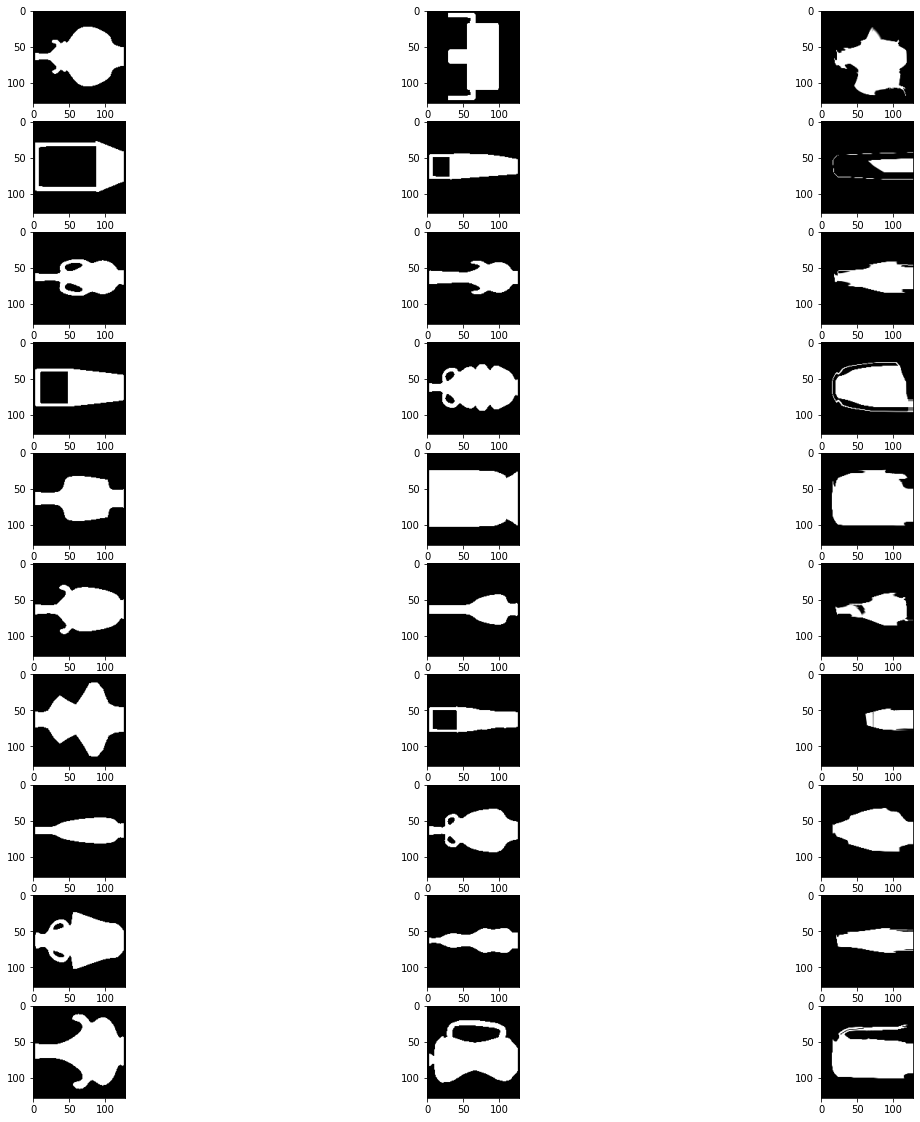

In [ ]:
validate(model,valid_loader_source, valid_loader_target, GRID_SIZE, visualize=True, get_loss=True)

In [ ]:
summary(model, (2, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1            [-1, 2, 64, 64]               0
            Conv2d-2           [-1, 20, 60, 60]           1,020
              ReLU-3           [-1, 20, 60, 60]               0
         MaxPool2d-4           [-1, 20, 30, 30]               0
            Conv2d-5           [-1, 20, 26, 26]          10,020
              ReLU-6           [-1, 20, 26, 26]               0
         MaxPool2d-7           [-1, 20, 13, 13]               0
            Conv2d-8           [-1, 20, 12, 12]           1,620
              ReLU-9           [-1, 20, 12, 12]               0
        MaxPool2d-10             [-1, 20, 6, 6]               0
           Conv2d-11             [-1, 20, 2, 2]          10,020
             ReLU-12             [-1, 20, 2, 2]               0
          Flatten-13                   [-1, 80]               0
           Linear-14                   

In [ ]:
#save the current model
from google.colab import drive
drive.mount('/content/gdrive')
modelname = 'ALIGNet_model'
path = '{modelname}'
torch.save(model.state_dict(), 'ALIGNet_model')

KeyboardInterrupt: ignored

In [ ]:
tr_tar_dl_aug, tr_src_dl_aug, val_tar_dl_aug, val_src_dl_aug, test_tar_dl_aug, test_src_dl_aug = get_data(augment=True)
tr_tar_dl, tr_src_dl, val_tar_dl, val_src_dl, test_tar_dl, test_src_dl = get_data()
tr_tar = [tr_tar_dl, tr_tar_dl_aug]
tr_src = [tr_src_dl, tr_src_dl_aug]
print(len(tr_tar_dl))
print(len(tr_src_dl))
model2 = ALIGNet(GRID_SIZE)
e_loss =  run_model(model2, tr_src, tr_tar, GRID_SIZE)


540
540


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([1, 8, 8])) that is different to the input size (torch.Size([5, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Loss in Epoch 0: 0.18437041342258453
Loss in Epoch 1: 0.1405005306005478
Loss in Epoch 2: 0.13432160019874573
Loss in Epoch 3: 0.12552788853645325
Loss in Epoch 4: 0.1188654750585556
Loss in Epoch 5: 0.11485375463962555
Loss in Epoch 6: 0.10987359285354614
Loss in Epoch 7: 0.10736198723316193
Loss in Epoch 8: 0.10469857603311539
Loss in Epoch 9: 0.10224100202322006
Loss in Epoch 10: 0.10091306269168854
Loss in Epoch 11: 0.0982881635427475
Loss in Epoch 12: 0.09836001694202423
Loss in Epoch 13: 0.09537001699209213
Loss in Epoch 14: 0.09516376256942749
Loss in Epoch 15: 0.09334629774093628
Loss in Epoch 16: 0.09335628896951675
Loss in Epoch 17: 0.09174416214227676
Loss in Epoch 18: 0.09123078733682632
Loss in Epoch 19: 0.0907410979270935
Loss in Epoch 20: 0.08956308662891388
Loss in Epoch 21: 0.09035835415124893
Loss in Epoch 22: 0.08900553733110428
Loss in Epoch 23: 0.08849313110113144
Loss in Epoch 24: 0.08832363784313202
Loss in Epoch 25: 0.08820883184671402
Loss in Epoch 26: 0.087482

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid b

Average Loss: 0.07236599177122116


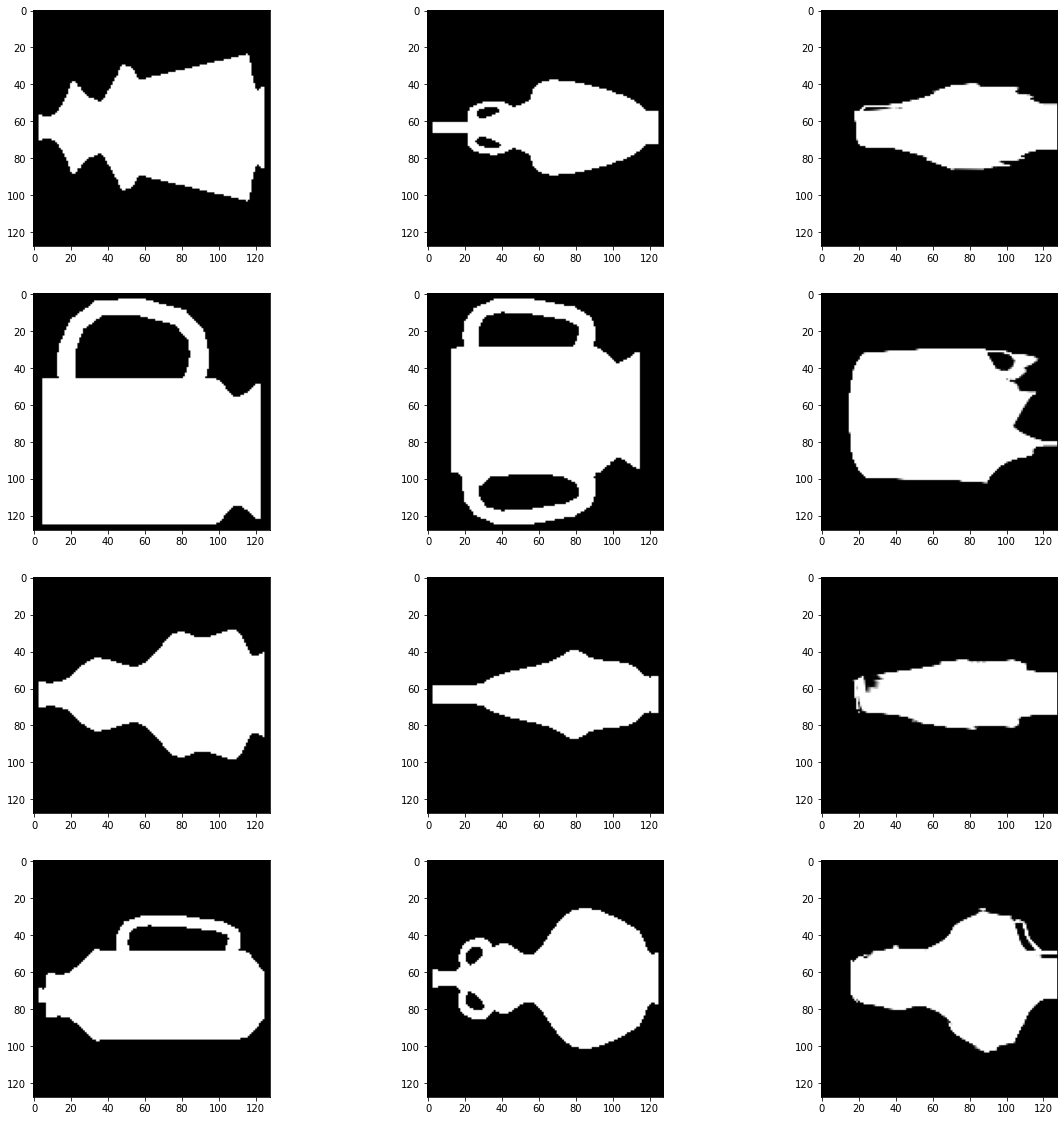

In [ ]:
tr_tar_dl2, tr_src_dl2, val_tar_dl2, val_src_dl2, test_tar_dl2, test_src_dl2 = get_data()
tr_tar_dl3, tr_src_dl3, val_tar_dl3, val_src_dl3, test_tar_dl3, test_src_dl3 = get_data()

validate(model2,test_src_dl2, test_src_dl3, GRID_SIZE, visualize=True, get_loss=True)


In [ ]:
tr_tar_dl2, tr_src_dl2, val_tar_dl2, val_src_dl2, test_tar_dl2, test_src_dl2 = get_data()
tr_tar_dl2_aug, tr_src_dl2_aug, val_tar_dl2_aug, val_src_dl2_aug, test_tar_dl2_aug, test_src_dl2_aug = get_data(augment=True)
tr_tar2 = [tr_tar_dl2, tr_tar_dl2_aug]
tr_src2 = [tr_src_dl2, tr_src_dl2_aug]
e_loss =  run_model(model2, tr_src2, tr_tar2, GRID_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([1, 8, 8])) that is different to the input size (torch.Size([5, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Loss in Epoch 0: 0.09208602458238602
Loss in Epoch 1: 0.08957851678133011
Loss in Epoch 2: 0.08918869495391846
Loss in Epoch 3: 0.08755718171596527
Loss in Epoch 4: 0.08757605403661728
Loss in Epoch 5: 0.08707035332918167
Loss in Epoch 6: 0.0868552178144455
Loss in Epoch 7: 0.08627740293741226
Loss in Epoch 8: 0.08560732007026672
Loss in Epoch 9: 0.0848805233836174
Loss in Epoch 10: 0.0861150473356247
Loss in Epoch 11: 0.08543769270181656
Loss in Epoch 12: 0.08514024317264557
Loss in Epoch 13: 0.0840817391872406
Loss in Epoch 14: 0.08438002318143845
Loss in Epoch 15: 0.08445902168750763
Loss in Epoch 16: 0.08468138426542282
Loss in Epoch 17: 0.08468493074178696
Loss in Epoch 18: 0.08381429314613342
Loss in Epoch 19: 0.08390676230192184
Loss in Epoch 20: 0.084251269698143
Loss in Epoch 21: 0.08330763131380081
Loss in Epoch 22: 0.08348929136991501
Loss in Epoch 23: 0.08419328182935715
Loss in Epoch 24: 0.08266627043485641
Loss in Epoch 25: 0.08286742120981216
Loss in Epoch 26: 0.08356551

In [ ]:
tr_tar_dl2, tr_src_dl2, val_tar_dl2, val_src_dl2, test_tar_dl2, test_src_dl2 = get_data()
tr_tar_dl2_aug, tr_src_dl2_aug, val_tar_dl2_aug, val_src_dl2_aug, test_tar_dl2_aug, test_src_dl2_aug = get_data(augment=True)
tr_tar2 = [tr_tar_dl2, tr_tar_dl2_aug]
tr_src2 = [tr_src_dl2, tr_src_dl2_aug]
e_loss =  run_model(model2, tr_src2, tr_tar2, GRID_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([1, 8, 8])) that is different to the input size (torch.Size([5, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Loss in Epoch 0: 0.08474747091531754
Loss in Epoch 1: 0.08351997286081314
Loss in Epoch 2: 0.08230229467153549
Loss in Epoch 3: 0.08179407566785812
Loss in Epoch 4: 0.08129601180553436
Loss in Epoch 5: 0.08142264932394028
Loss in Epoch 6: 0.0815359354019165
Loss in Epoch 7: 0.08137787878513336
Loss in Epoch 8: 0.08055983483791351
Loss in Epoch 9: 0.08106211572885513
Loss in Epoch 10: 0.08106938749551773
Loss in Epoch 11: 0.08063650876283646
Loss in Epoch 12: 0.08010914921760559
Loss in Epoch 13: 0.08022239804267883
Loss in Epoch 14: 0.08006511628627777
Loss in Epoch 15: 0.08041730523109436
Loss in Epoch 16: 0.08077634125947952
Loss in Epoch 17: 0.08035630732774734
Loss in Epoch 18: 0.08015590161085129
Loss in Epoch 19: 0.08016325533390045
Loss in Epoch 20: 0.07987941801548004
Loss in Epoch 21: 0.08053357154130936
Loss in Epoch 22: 0.07986228168010712
Loss in Epoch 23: 0.0794110968708992
Loss in Epoch 24: 0.07968541234731674
Loss in Epoch 25: 0.07977235317230225
Loss in Epoch 26: 0.0796

In [ ]:
tr_tar_dl2, tr_src_dl2, val_tar_dl2, val_src_dl2, test_tar_dl2, test_src_dl2 = get_data()
tr_tar_dl2_aug, tr_src_dl2_aug, val_tar_dl2_aug, val_src_dl2_aug, test_tar_dl2_aug, test_src_dl2_aug = get_data(augment=True)
tr_tar2 = [tr_tar_dl2, tr_tar_dl2_aug]
tr_src2 = [tr_src_dl2, tr_src_dl2_aug]
e_loss =  run_model(model2, tr_src2, tr_tar2, GRID_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([1, 8, 8])) that is different to the input size (torch.Size([5, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Loss in Epoch 0: 0.08258145302534103
Loss in Epoch 1: 0.08006472140550613
Loss in Epoch 2: 0.07914100587368011
Loss in Epoch 3: 0.07843068242073059
Loss in Epoch 4: 0.07851817458868027
Loss in Epoch 5: 0.07849926501512527
Loss in Epoch 6: 0.07777156680822372
Loss in Epoch 7: 0.07811059057712555
Loss in Epoch 8: 0.07708991318941116
Loss in Epoch 9: 0.0771375522017479
Loss in Epoch 10: 0.07755886763334274
Loss in Epoch 11: 0.07805771380662918
Loss in Epoch 12: 0.07767293602228165
Loss in Epoch 13: 0.07636292278766632
Loss in Epoch 14: 0.07619386166334152
Loss in Epoch 15: 0.07676141709089279
Loss in Epoch 16: 0.07672557979822159
Loss in Epoch 17: 0.07659810036420822
Loss in Epoch 18: 0.07622036337852478
Loss in Epoch 19: 0.07663632184267044
Loss in Epoch 20: 0.07622643560171127
Loss in Epoch 21: 0.07659241557121277
Loss in Epoch 22: 0.07704607397317886
Loss in Epoch 23: 0.07629252225160599
Loss in Epoch 24: 0.07616221159696579
Loss in Epoch 25: 0.07650734484195709
Loss in Epoch 26: 0.076

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid b

Average Loss: 0.04887055233120918


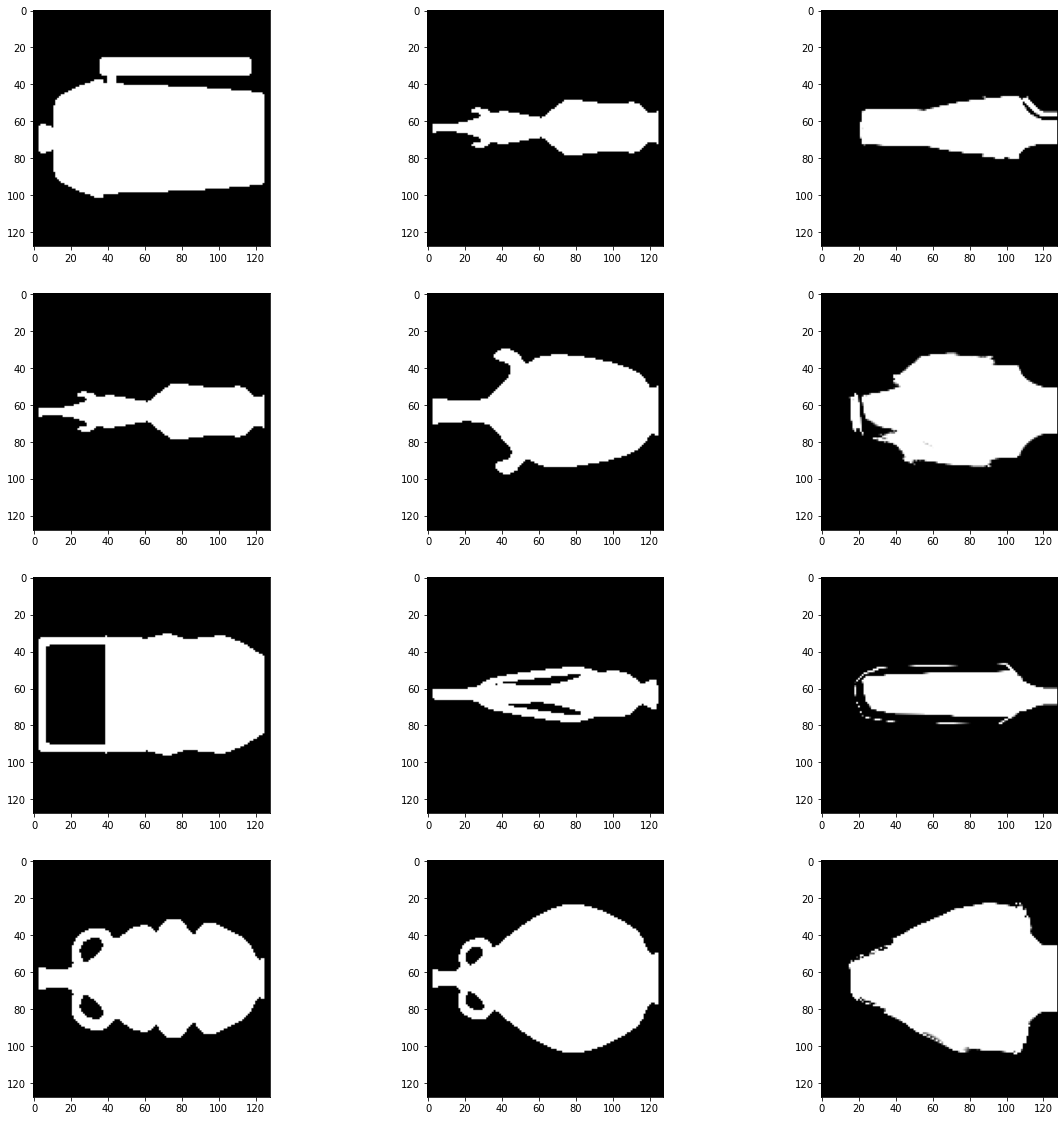

In [ ]:
tr_tar_dl2, tr_src_dl2, val_tar_dl2, val_src_dl2, test_tar_dl2, test_src_dl2 = get_data()
tr_tar_dl3, tr_src_dl3, val_tar_dl3, val_src_dl3, test_tar_dl3, test_src_dl3 = get_data()

validate(model2,test_src_dl2, test_src_dl3, GRID_SIZE, visualize=True, get_loss=True)

In [ ]:
tr_tar_dl2, tr_src_dl2, val_tar_dl2, val_src_dl2, test_tar_dl2, test_src_dl2 = get_data()
tr_tar_dl2_aug, tr_src_dl2_aug, val_tar_dl2_aug, val_src_dl2_aug, test_tar_dl2_aug, test_src_dl2_aug = get_data(augment=True)
tr_tar2 = [tr_tar_dl2, tr_tar_dl2_aug]
tr_src2 = [tr_src_dl2, tr_src_dl2_aug]
e_loss =  run_model(model2, tr_src2, tr_tar2, GRID_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([1, 8, 8])) that is different to the input size (torch.Size([5, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Loss in Epoch 0: 0.08396468311548233
Loss in Epoch 1: 0.08229728788137436
Loss in Epoch 2: 0.08159228414297104
Loss in Epoch 3: 0.08034839481115341
Loss in Epoch 4: 0.07968565076589584
Loss in Epoch 5: 0.07963845878839493
Loss in Epoch 6: 0.07930552959442139
Loss in Epoch 7: 0.07899850606918335
Loss in Epoch 8: 0.07878526300191879
Loss in Epoch 9: 0.07850458472967148
Loss in Epoch 10: 0.07878536731004715
Loss in Epoch 11: 0.07779303193092346
Loss in Epoch 12: 0.07777256518602371
Loss in Epoch 13: 0.0780167505145073
Loss in Epoch 14: 0.07694994658231735
Loss in Epoch 15: 0.07749072462320328
Loss in Epoch 16: 0.07728718221187592
Loss in Epoch 17: 0.07708875834941864
Loss in Epoch 18: 0.07741305232048035
Loss in Epoch 19: 0.07770946621894836
Loss in Epoch 20: 0.0770430862903595
Loss in Epoch 21: 0.07790607213973999
Loss in Epoch 22: 0.0770968645811081
Loss in Epoch 23: 0.0774863138794899
Loss in Epoch 24: 0.07646074146032333
Loss in Epoch 25: 0.07746677100658417
Loss in Epoch 26: 0.077571

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid b

Average Loss: 0.04876699671149254


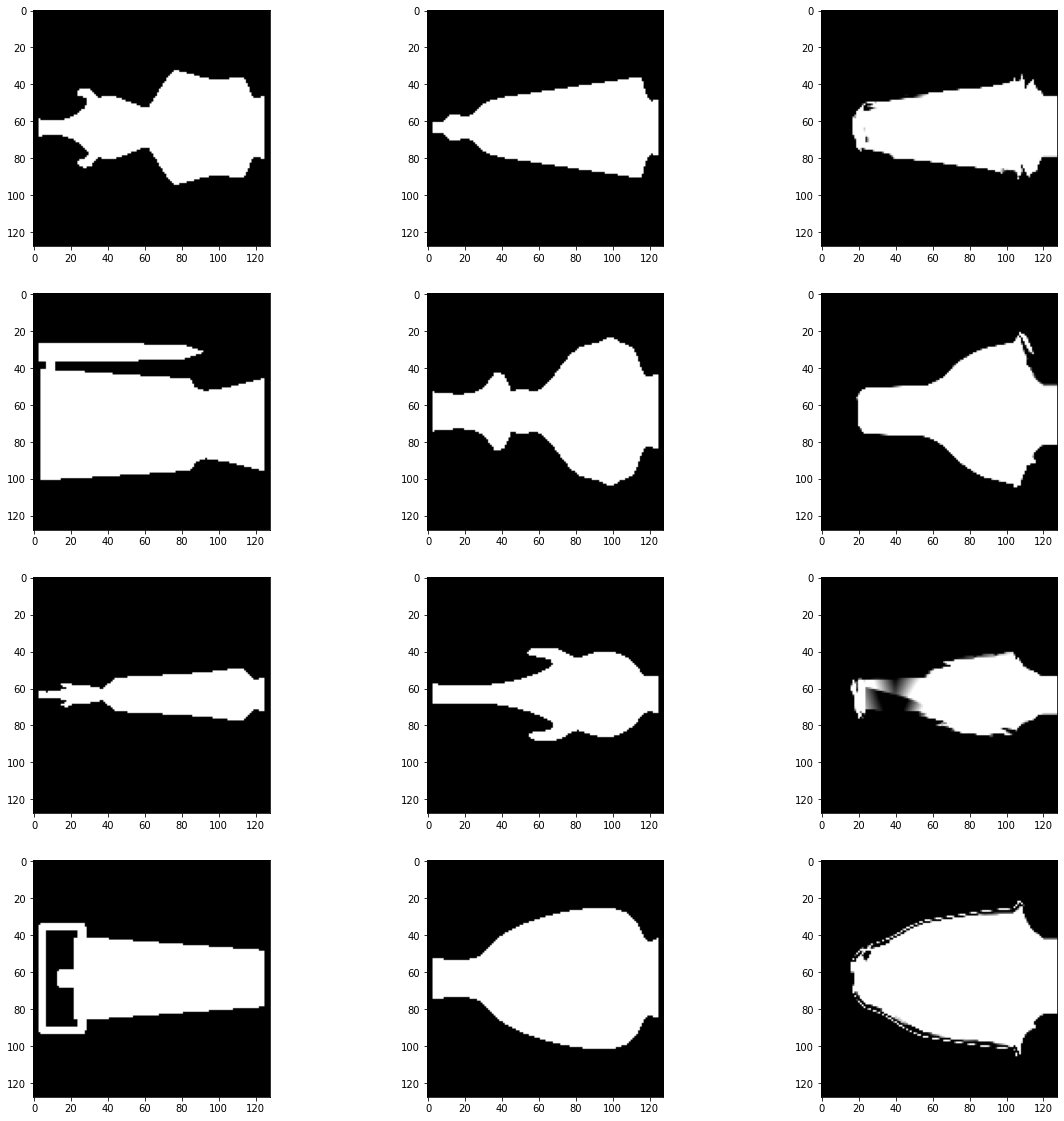

In [ ]:
tr_tar_dl2, tr_src_dl2, val_tar_dl2, val_src_dl2, test_tar_dl2, test_src_dl2 = get_data()
tr_tar_dl3, tr_src_dl3, val_tar_dl3, val_src_dl3, test_tar_dl3, test_src_dl3 = get_data()

validate(model2,test_src_dl2, test_src_dl3, GRID_SIZE, visualize=True, get_loss=True)

In [ ]:
tr_tar_dl2, tr_src_dl2, val_tar_dl2, val_src_dl2, test_tar_dl2, test_src_dl2 = get_data()
tr_tar_dl2_aug, tr_src_dl2_aug, val_tar_dl2_aug, val_src_dl2_aug, test_tar_dl2_aug, test_src_dl2_aug = get_data(augment=True)
tr_tar2 = [tr_tar_dl2, tr_tar_dl2_aug]
tr_src2 = [tr_src_dl2, tr_src_dl2_aug]
e_loss =  run_model(model2, tr_src2, tr_tar2, GRID_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([1, 8, 8])) that is different to the input size (torch.Size([5, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Loss in Epoch 0: 0.08109558373689651
Loss in Epoch 1: 0.07924408465623856
Loss in Epoch 2: 0.0787302628159523
Loss in Epoch 3: 0.07863961905241013
Loss in Epoch 4: 0.07776928693056107
Loss in Epoch 5: 0.07739739865064621
Loss in Epoch 6: 0.07724591344594955
Loss in Epoch 7: 0.07702550292015076
Loss in Epoch 8: 0.07690286636352539
Loss in Epoch 9: 0.07682052254676819
Loss in Epoch 10: 0.07685577869415283
Loss in Epoch 11: 0.07661761343479156
Loss in Epoch 12: 0.07661233097314835
Loss in Epoch 13: 0.07674508541822433
Loss in Epoch 14: 0.0764671042561531
Loss in Epoch 15: 0.07608810067176819
Loss in Epoch 16: 0.07634496688842773
Loss in Epoch 17: 0.07648668438196182
Loss in Epoch 18: 0.07589660584926605
Loss in Epoch 19: 0.07579940557479858
Loss in Epoch 20: 0.07580941915512085
Loss in Epoch 21: 0.07559341192245483
Loss in Epoch 22: 0.07569953054189682
Loss in Epoch 23: 0.07569199055433273
Loss in Epoch 24: 0.07622429728507996
Loss in Epoch 25: 0.07639874517917633
Loss in Epoch 26: 0.0758

In [ ]:
#save the current model
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
modelname = 'ALIGNet_model2'
path = '{modelname}'
torch.save(model2.state_dict(), 'ALIGNet_model2')

Mounted at /content/gdrive


In [ ]:
tr_tar_dl_aug, tr_src_dl_aug, val_tar_dl_aug, val_src_dl_aug, test_tar_dl_aug, test_src_dl_aug = get_data(augment=True)
tr_tar_dl, tr_src_dl, val_tar_dl, val_src_dl, test_tar_dl, test_src_dl = get_data()
tr_tar = [tr_tar_dl, tr_tar_dl_aug]
tr_src = [tr_src_dl, tr_src_dl_aug]

model3 = ALIGNet(GRID_SIZE)
e_loss =  run_model(model3, tr_src, tr_tar, GRID_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired

Loss in Epoch 0: 0.1889321357011795
Loss in Epoch 1: 0.13792766630649567
Loss in Epoch 2: 0.12621745467185974
Loss in Epoch 3: 0.12077644467353821
Loss in Epoch 4: 0.1144077405333519
Loss in Epoch 5: 0.10903032124042511
Loss in Epoch 6: 0.1069701537489891
Loss in Epoch 7: 0.10280518233776093
Loss in Epoch 8: 0.10135971009731293
Loss in Epoch 9: 0.09834428131580353
Loss in Epoch 10: 0.0962173119187355
Loss in Epoch 11: 0.0944080576300621
Loss in Epoch 12: 0.09286976605653763
Loss in Epoch 13: 0.09135595709085464
Loss in Epoch 14: 0.09043709933757782
Loss in Epoch 15: 0.09009453654289246
Loss in Epoch 16: 0.08764877170324326
Loss in Epoch 17: 0.08749715983867645
Loss in Epoch 18: 0.08656906336545944
Loss in Epoch 19: 0.0852319523692131
Loss in Epoch 20: 0.08482452481985092
Loss in Epoch 21: 0.08525294810533524
Loss in Epoch 22: 0.08383442461490631
Loss in Epoch 23: 0.08367138355970383
Loss in Epoch 24: 0.08316197991371155
Loss in Epoch 25: 0.08199218660593033
Loss in Epoch 26: 0.08251825